In [130]:
# Python modules
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np

# Custom module(s)
from load_data import load_gzip_txt_data

Importing the data.

In [131]:
BASE_PATH = './data/RateBeer/'
MAX_ENTRIES = int(1e6)

# Importing ratings
df = load_gzip_txt_data(
    path=os.path.join(BASE_PATH, "ratings.txt.gz"),
    attributes=["beer_id", "abv", "rating", "user_id"],
    max_entries=MAX_ENTRIES,
)
df["abv"] = df["abv"].astype(float)
df["rating"] = df["rating"].astype(float)
df.dropna(inplace=True)
df['user_id'] = df['user_id'].astype(int)

# Importing user data
users = pd.read_csv(
    os.path.join(BASE_PATH, "users.csv"),
)
users['location'] = users['location'].astype(str)

# Merging user data with ratings
df = pd.merge(left=df, right=users, on="user_id", how="left")

# Adding continent
def get_continent(location: str) -> str:
    if not isinstance(location, str): # NOTE: This should never trigger, but we never know...
        return "Other"
    european_countries = [
        "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
        "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
        "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France",
        "Georgia", "Germany", "Gibraltar", "Greece", "Hungary", "Iceland",
        "Ireland", "Italy", "Jersey", "Kazakhstan", "Kosovo", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova",
        "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
        "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino",
        "Scotland", "Serbia", "Slovakia", "Slovak Republic", "Slovenia",
        "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "Vatican City",
        "Wales"
    ] # NOTE: This list has been defined in P2 milestone.
    if location in european_countries:
        return "Europe"
    elif location.startswith("United States") or location == 'Canada' or location == 'Mexico':
        return "America"
    else:
        return "Other"
df["continent"] = df["location"].apply(get_continent)

display(df)

Loading data from:  ./data/RateBeer/ratings.txt.gz


16999997it [00:09, 1858865.18it/s]


,beer_id,abv,rating,user_id,nbr_ratings,user_name,joined,location,continent
0,410549,5.0,2.0,175852,1890.0,Manslow,1.337508e+09,Poland,Europe
1,105273,5.2,1.9,442761,89.0,MAGICuenca91,1.484046e+09,Spain,Europe
2,105273,5.2,1.6,288889,169.0,Sibarh,1.384600e+09,Poland,Europe
3,105273,5.2,1.5,250510,3371.0,fombe89,1.363950e+09,Spain,Europe
4,105273,5.2,1.9,122778,13043.0,kevnic2008,1.296644e+09,Germany,Europe
...,...,...,...,...,...,...,...,...,...
984594,39904,4.9,3.1,19400,23458.0,Papsoe,1.106910e+09,Denmark,Europe
984595,39904,4.9,2.9,5328,35316.0,Ungstrup,1.028714e+09,Denmark,Europe
984596,39904,4.9,2.9,1880,7409.0,motelpogo,1.002103e+09,Czech Republic,Europe
984597,39904,4.9,2.1,832,5207.0,duff,9.889704e+08,Denmark,Europe


Defining some functions.

In [132]:
def get_fit_equation(
        result: scipy.stats._stats_mstats_common.LinregressResult,
        decilams: int = 2
    ) -> str:
    """Returns the equation of the regression line."""
    return f'$y = ({result.slope:.{decilams}f}\\pm{result.stderr:.{decilams}f})x \
    + ({result.intercept:.{decilams}f}\\pm{result.intercept_stderr:.{decilams}f})$'

## Naive model

In the following, we will use a naive model, ie. only compare the ABV with the ratings, without any other considerations.

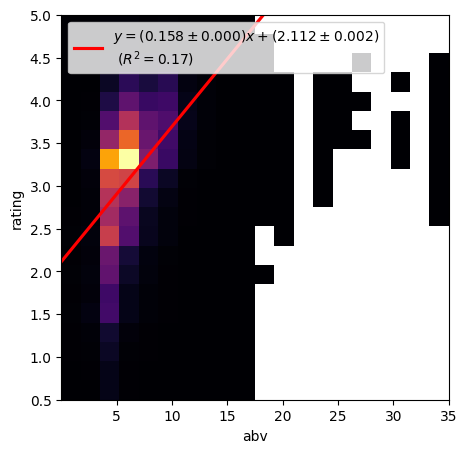

<Figure size 500x500 with 0 Axes>

In [133]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(5, 5))

# Drawing the background histogram
plt.figure(figsize=(5, 5))
sns.histplot(
    data=df,
    x="abv",
    y="rating",
    bins=20, # NOTE: There are only ~50 unique values for ratings.
    cmap="inferno",
    ax=ax,
)

# Drawing the regression line
regplot = sns.regplot(
    data=df,
    x="abv",
    y="rating",
    scatter=False,
    line_kws={'color':'r', 'alpha':1.0},
    ax=ax,
)

# Computing the regression and some statistics
x = df['abv'].values
y = df['rating'].values
result = scipy.stats.linregress(x=x, y=y)

# Finalizing the plot
legend_text = f'{get_fit_equation(result, 3)}\n ($R^2 = {result.rvalue**2:.2f}$)'
ax.legend([legend_text], loc='upper left')
ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
plt.show()

Looking at the figure above, it seems clear that the naive model performs pretty poorly (because of the high $R^2$). Thus, we won't probably be able to explain the ratings only by looking at the ABV.

Though, let's still compare the naive model when considering only Americans and Europeans. For this, let's start by check if the dataset is balanced.

In [134]:
print(f"There are " + str(len(df.query('continent == "Europe"'))) + " ratings from Europe.")
print(f"There are " + str(len(df.query('continent == "America"'))) + " ratings from North America.")

There are 491962 ratings from Europe.
There are 423038 ratings from North America.


For the purpose of what we are going to do, the dataset is balanced enough. But we could also perform a one-to-one matching.

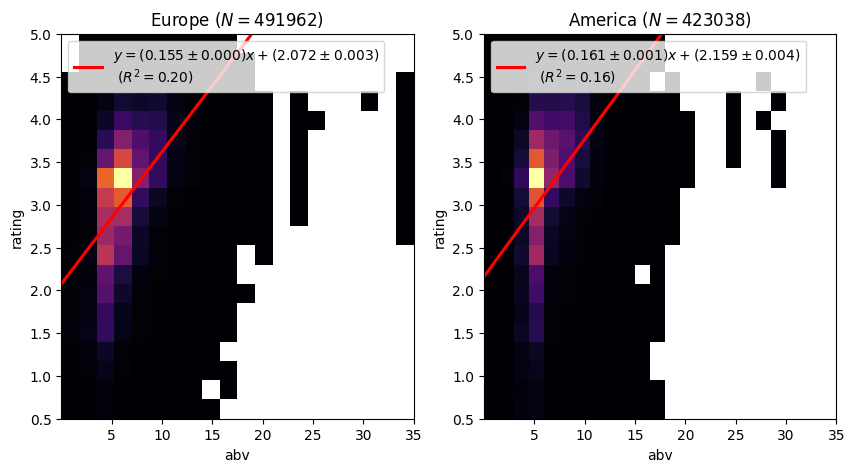

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [136]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

fit_results = []

for continent_index, continent in enumerate(['Europe', 'America']):

    df_ = df.query(f'continent == @continent')

    # Drawing the background histogram
    plt.figure(figsize=(5, 5))
    sns.histplot(
        data=df_,
        x="abv",
        y="rating",
        bins=20, # NOTE: There are only ~50 unique values for ratings.
        cmap="inferno",
        ax=axes[continent_index],
    )

    # Drawing the regression line
    regplot = sns.regplot(
        data=df_,
        x="abv",
        y="rating",
        scatter=False,
        line_kws={'color':'r', 'alpha':1.0},
        ax=axes[continent_index],
    )

    # Computing the regression and some statistics
    x = df_['abv'].values
    y = df_['rating'].values
    result = scipy.stats.linregress(x=x, y=y)
    fit_results.append(result)

    # Finalizing the plot
    legend_text = f'{get_fit_equation(result, 3)}\n ($R^2 = {result.rvalue**2:.2f}$)'
    axes[continent_index].legend([legend_text], loc='upper left')
    axes[continent_index].set(
        xlim=(df['abv'].min(), df['abv'].max()),
        ylim=(df['rating'].min(), df['rating'].max()),
        title=f'{continent} ($N={len(df_)}$)',
    )

plt.show()

To see if the two datasets do follow the same trend, we can look more into details at the models' coefficients Below we have plotted the values of each of them as well as their standard error, supposing it is normally distributed.

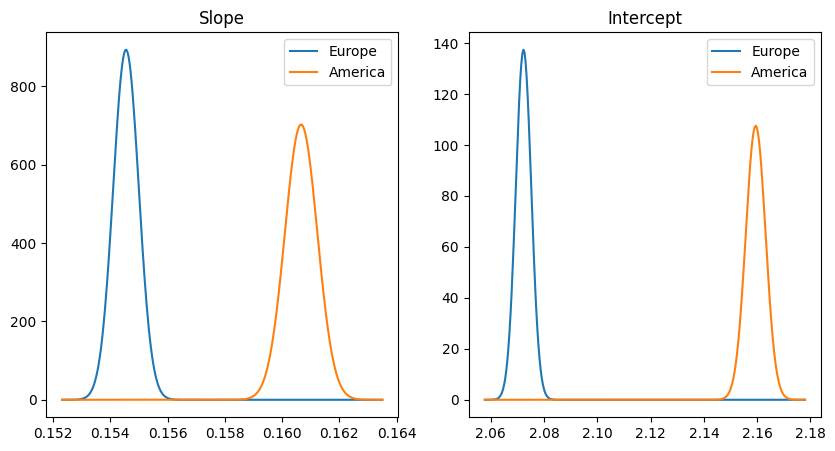

In [ ]:
def gaussian(loc: float, scale: float, x: float) -> float:
    """Returns the value of a Gaussian distribution at a given point."""
    return scipy.stats.norm(loc=loc, scale=scale).pdf(x)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

for continent_index, continent in enumerate(['Europe', 'America']):
    result = fit_results[continent_index]

    # Plot the slope informations
    x = np.linspace(
        start=min([result.slope - 5 * result.stderr for result in fit_results]),
        stop=max([result.slope + 5 * result.stderr for result in fit_results]),
        num=300,
    )
    y = gaussian(loc=result.slope, scale=result.stderr, x=x)
    axes[0].plot(x, y, label=continent)
    
    # Plot the intercept informations
    x = np.linspace(
        start=min([result.intercept - 5 * result.intercept_stderr for result in fit_results]),
        stop=max([result.intercept + 5 * result.intercept_stderr for result in fit_results]),
        num=300,
    )
    y = gaussian(loc=result.intercept, scale=result.intercept_stderr, x=x)
    axes[1].plot(x, y, label=continent)

axes[0].set_title('Slope')
axes[1].set_title('Intercept')
axes[0].legend()
axes[1].legend()


By visual inspection, it seems that altough the two distributions may have the same slope, we can argue that the intercepts are significantly different. 

**TODO: use some more rigorous statistical test to check if the two distributions are significantly different.**

Below we show the effect of the standard error on the slope and intercept of the models, by drawing a whole bunch of lines. In other words, the lines drawn below are other plausible fits that would fit the linear model.

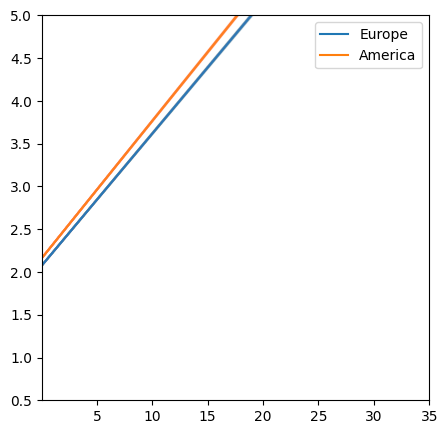

In [ ]:
plt.figure(figsize=(5, 5))

for i in range(100):

    slope = fit_results[0].slope + np.random.normal(loc=0, scale=fit_results[0].stderr)
    intercept = fit_results[0].intercept + np.random.normal(loc=0, scale=fit_results[0].intercept_stderr)
    x = np.linspace(0, 20, 2)
    y = slope*x + intercept
    plt.plot(x, y, color='tab:blue', alpha=0.02)

    slope = fit_results[1].slope + np.random.normal(loc=0, scale=fit_results[0].stderr)
    intercept = fit_results[1].intercept + np.random.normal(loc=0, scale=fit_results[0].intercept_stderr)
    x = np.linspace(0, 20, 2)
    y = slope*x + intercept
    plt.plot(x, y, color='tab:orange', alpha=0.02)

plt.plot(0,1, color='tab:blue', label='Europe') # NOTE: Dummy plot for legend.
plt.plot(0,1, color='tab:orange', label='America') # NOTE: Dummy plot for legend.
plt.xlim(df['abv'].min(), df['abv'].max())
plt.ylim(df['rating'].min(), df['rating'].max())
plt.legend()
plt.show()